In [54]:
# TODO: Använd branchen gridsearch 
# TODO: Ta fram data från några utvalda kryptovalutor - Använd binance API (se my_crypto.py)
# TODO: Gör viss preprocessing per kryptovaluta till separate df
# TODO: Gör en merge av alla kryptovalutors df
# TODO: Sätt tomorrows up/down (1/0) till en kolumn i df som target
# TODO: Lägg till inflationskolumnen

# TODO: Gör en split av df till train och test
# TODO: Gör en GridSearchCV för en pipeline som innehåller en StandardScaler för olika modeller
# TODO: Skall vi gå vidare med övermorgon också?

# TODO: Gå vidare med logiken i my_crypto.py

In [55]:
import sklearn
import xgboost as xgb
import catboost
from catboost import CatBoostClassifier

# from pytrends.request import TrendReq
# import pytrends
import sys
import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import ta
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# plt.style.use('fivethirtyeight')
pd.set_option('display.width', 200)
import plotly.express as px
import streamlit as st
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

#Import other useful libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from IPython.display import display
# set display witdh to 200
pd.set_option('display.width', 200)
# set display height to 500
pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
# pd.options.display.precision = 4      # default 6
import logging

# Starta upp logging och inkluder rad nummer
logging.basicConfig(level=logging.INFO, filemode='w', filename='krypto.log', force=True,
                    encoding='utf-8', format= '%(asctime)s - %(levelname)s - %(lineno)d - %(message)s')
logging.info('Startar')


In [56]:
print('Versioner av softvara som används i denna notebook:')
# print numpy version
print('numpy=={}'.format(np.__version__))
# print pandas version
print('pandas=={}'.format(pd.__version__))
# print matplotlib version
print('matplotlib=={}'.format(plt.matplotlib.__version__)) # type: ignore
# print yfinance version
print('yfinance=={}'.format(yf.__version__))
# print pytreands version
print('pytrends==4.8.0') 
# print python-dateutil version
print('python-dateutil==2.8.2')
# print ta version
print('ta==0.10.2')
# print streamlit version
print('streamlit=={}'.format(st.__version__))
print('xgboost=={}'.format(xgb.__version__))
print('catboost=={}'.format(catboost.__version__))

print('sklearn=={}'.format(sklearn.__version__))
#print google version
print('google-crc32==1.1.2')
# print pandas-ta version
print('pandas-ta==0.3.14b0')
# print plotly version
print('plotly==5.3.1')



Versioner av softvara som används i denna notebook:
numpy==1.23.5
pandas==1.4.4
matplotlib==3.7.0
yfinance==0.2.12
pytrends==4.8.0
python-dateutil==2.8.2
ta==0.10.2
streamlit==1.14.0
xgboost==1.7.1
catboost==1.1.1
sklearn==1.0.2
google-crc32==1.1.2
pandas-ta==0.3.14b0
plotly==5.3.1


In [57]:
# TODO Vilka kryptovalutor ska vi använda?
tickers = ['BTC-USD','ETH-USD','BCH-USD','XRP-USD','ZRX-USD']
horizons=[2,5,15,30,60,90,250]

In [58]:
def beräkna_rolling_mean(df, ticker_names, window=20):
    # Funktionen används inte just nu
    rolling_mean=pd.DataFrame()
    for ticker_name in ticker_names:
        df[ticker_name+'-rolling']= df[ticker_name].rolling(window=window).mean()
        
    df.dropna(inplace=True)   
    return df   

def beräkna_cumulative_return(df, ticker_names):
    # Funktionen används inte just nu
    cumulative_return={}
    for ticker_name in ticker_names:
        cumulative_return[ticker_name] = (df[ticker_name].iloc[-1]/df[ticker_name].iloc[0]-1)
    return cumulative_return

## Get inflation data US and SE

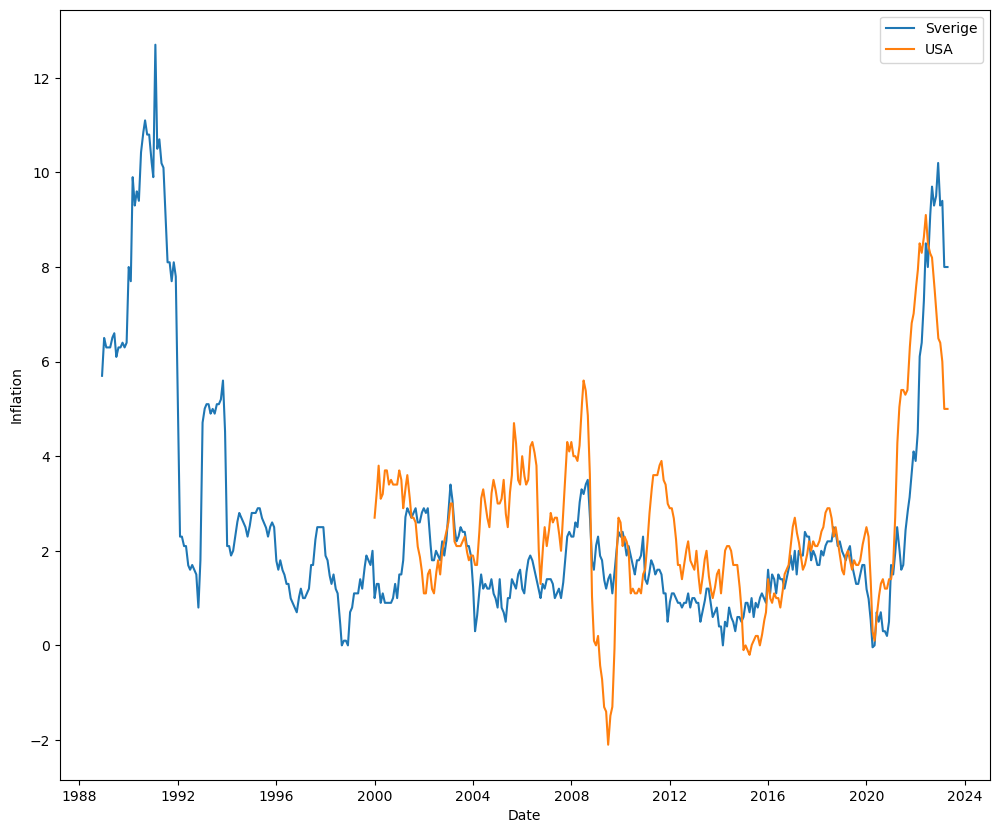

In [59]:
def add_horizon_columns(inflation, horizons):
    # print(horizons)
    for horizon in  horizons:
        # print(horizon)
        inflation['US_inflation_'+str(horizon)] = inflation['US_inflation'].rolling(horizon, 1).mean()
        inflation['SE_inflation_'+str(horizon)] = inflation['SE_inflation'].rolling(horizon, 1).mean()
                
        # print(inflation.columns)        
    return inflation


def initiate_data(inflation, df_dates, lang_dict, value_name):
    # display(inflation)
    inflation = inflation.melt(id_vars=['Year'], var_name='month', value_name=value_name)

    # use lang_dict to translate month names to numbers
    inflation['month'] = inflation['month'].map(lang_dict)

    inflation['date'] = pd.to_datetime(inflation['Year'].astype(str) + '-' + inflation['month'].astype(str))
    inflation.set_index('date', inplace=True)
    inflation.drop(['Year', 'month'], axis=1, inplace=True)
    inflation = df_dates.merge(inflation, how='left', left_on='date', right_index=True)
    inflation.set_index('date', inplace=True)
    inflation[value_name] = inflation[value_name].astype(str)
    inflation[value_name] = inflation[value_name].str.replace(',', '.')
    inflation[value_name] = inflation[value_name].str.replace(chr(8209), chr(45))
    inflation[value_name] = inflation[value_name].astype(float)
    inflation[value_name].interpolate(method='linear', inplace=True)
    return inflation


@st.cache_data
def get_inflation_data(graph=False):
    # Explain this function here        
        

    df_dates = pd.DataFrame(pd.date_range('1988-12-01', pd.to_datetime('today').date()), columns=['date'])
    
    US_inflation = pd.read_html('https://www.usinflationcalculator.com/inflation/current-inflation-rates/')
    US_inflation = US_inflation[0]
    # replace the cell including string starting with "Avail" with the NaN
    US_inflation.replace(to_replace=r'^Avail.*$', value=np.nan, regex=True, inplace=True)
    # set the first row as the header and drop the first row
    US_inflation.columns = US_inflation.iloc[0]
    US_inflation.drop(US_inflation.index[0], inplace=True)
    US_inflation.drop('Ave', axis=1, inplace=True)

    SE_inflation = pd.read_html('https://www.scb.se/hitta-statistik/statistik-efter-amne/priser-och-konsumtion/konsumentprisindex/konsumentprisindex-kpi/pong/tabell-och-diagram/konsumentprisindex-med-fast-ranta-kpif-och-kpif-xe/kpif-12-manadersforandring/')
    SE_inflation = SE_inflation[0]
    SE_inflation.rename(columns={'År': 'Year'}, inplace=True)

    se_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', Maj='5', Jun='6', Jul='7', Aug='8', Sep='9', Okt='10', Nov='11', Dec='12')
    us_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', May='5', Jun='6', Jul='7', Aug='8', Sep='9', Oct='10', Nov='11', Dec='12')
    #
    SE_inflation = initiate_data(SE_inflation, df_dates, se_dict, value_name='SE_inflation')
    SE_inflation['SE_inflation'] = SE_inflation['SE_inflation'] / 10  # SE_inflation is in percent, divide by 10 to get decimal
    US_inflation = initiate_data(US_inflation, df_dates, us_dict,  value_name='US_inflation')

    if graph:
        # Do a simple plot
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.plot(SE_inflation.index, SE_inflation['SE_inflation'], label='Sverige')
        ax.plot(US_inflation.index, US_inflation['US_inflation'], label='USA')
        ax.set_xlabel('Date')
        ax.set_ylabel('Inflation')
        ax.legend()
        plt.show()

    # concat and set one column to US_index and the other to SE_index
    inflations = pd.concat([US_inflation, SE_inflation], axis=1)
    inflations = inflations.dropna()
    inflations = add_horizon_columns(inflations, [75,90,250])
    return inflations

inflations = get_inflation_data(graph=True)

In [60]:
display(list(inflations.columns))

['US_inflation',
 'SE_inflation',
 'US_inflation_75',
 'SE_inflation_75',
 'US_inflation_90',
 'SE_inflation_90',
 'US_inflation_250',
 'SE_inflation_250']

In [61]:
# fill up a dataframe with all days from 2005 up to today and set it as index
def get_all_dates():
    start_date = dt(2005, 1, 1)
    end_date = dt.today()
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    return df


## Ladda ner all data

In [62]:
def get_all(tickers):
    # Funktionen används inte just nu    
    df = pd.DataFrame()
    for ticker in tickers:
        # all_tickers = yf.download(ticker)
        df[ticker] = yf.download(ticker, period='max')['Close']
        
    df.index = pd.to_datetime(df.index)
    return df

df_org = get_all(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [63]:

def fit_predict(train, test, target, predictors, model, proba_val=None):
    
    if train[target].nunique() < 2:
        print('kolumner i train',train.columns)
        print('kolumner i test',test.columns)
        print('target',target)
        print('predictors',predictors)
        print('train\n',train[target].value_counts())
        print('test\n',test[target].value_counts())
        print(
            f"Skipping training for target {target} as it has only one unique value in the training data.")
        # stäng ner programmet
        sys.exit()
        
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined


### Beräkna ny kolumner (predictors)

In [64]:
def create_predictors(df_, ticker, target, horizons=[2,5,60,250], ETH_BTC=False):
    df = df_.copy()
    ticker_name = ticker[:3]
    print(ticker_name)
    # tidsintervall i dagar för rullande medelvärden
    # skulle helst ha med upp till 4 år men ETH har för få värden
    predictors=[]
     
    if ETH_BTC: 
        df['ETH_BTC_ratio'] = df['ETH-USD']/df['BTC-USD']
        predictors += ['ETH_BTC_ratio']
        
        df['ETH_BTC_lag1'] = df['ETH_BTC_ratio'].shift(1)
        predictors += ['ETH_BTC_lag1']
        
        df['ETH_BTC_lag2'] = df['ETH_BTC_ratio'].shift(2)
        predictors += ['ETH_BTC_lag2']
        
        if ticker not in ['BTC-USD', 'ETH-USD']:
            df[ticker_name+'_BTC_ratio'] = df[ticker]/df['BTC-USD']
            predictors += [ticker_name+'_BTC_ratio']
        
            df[ticker_name+'_BTC_lag1'] = df[ticker_name+'_BTC_ratio'].shift(1)
            predictors += [ticker_name+'_BTC_lag1']
            
            df[ticker_name+'_BTC_lag2'] = df[ticker_name+'_BTC_ratio'].shift(2)
            predictors += [ticker_name+'_BTC_lag2']
            
            df[ticker_name+'_ETH_ratio'] = df[ticker]/df['ETH-USD']
            predictors += [ticker_name+'_ETH_ratio']
        
            df[ticker_name+'_ETH_lag1'] = df[ticker_name+'_ETH_ratio'].shift(1)
            predictors += [ticker_name+'_ETH_lag1']
            
            df[ticker_name+'_ETH_lag2'] = df[ticker_name+'_ETH_ratio'].shift(2)
            predictors += [ticker_name+'_ETH_lag2']
    
    # Target
    # tomorrow's close price - alltså nästa dag
    df['Tomorrow'] = df[ticker].shift(-1)
    # after tomorrow's close price - alltså om två dagar
    df['After_tomorrow'] = df[ticker].shift(-2)
    df['y1'] = (df['Tomorrow'] > df[ticker]).astype(int)
    df['y2'] = (df['After_tomorrow'] > df[ticker]).astype(int)
    # df.dropna(inplace=True)

    for horizon in horizons:
        rolling_averages = df.rolling(horizon, min_periods=1).mean()

        ratio_column = f"Ratio_{horizon}"
        df[ratio_column] = df[ticker] / rolling_averages[ticker]
        
        rolling = df.rolling(horizon,closed='left', min_periods=1).mean()
        
        trend_column = f"Trend_{horizon}"
        target_name = 'Tomorrow' if target=='y1' else 'After_tomorrow'
        df[trend_column] = rolling[target_name]  

        predictors += [ratio_column, trend_column]

    # df['day_of_month'] = df.index.day
    # predictors += ['day_of_month']
    
    # df['day_of_week'] = df.index.dayofweek
    # predictors += ['day_of_week']
    
    # df['month'] = df.index.month
    # predictors += ['month']

    return df, predictors


Grafer för uppåt och nedåt predictions

# Skapa en GridSearchCV för olika modeller

In [65]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


In [82]:
### get the data ###
df_grid = get_all(tickers)
df_inflations = get_inflation_data(graph=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Vi gör viss preprocessing för en valuta i taget - nya kolumner

In [67]:
# tickers
df_grid[['BTC-USD', 'ZRX-USD']]


,BTC-USD,ZRX-USD
Date,,
2014-09-17,457.334015,NaN
2014-09-18,424.440002,NaN
2014-09-19,394.795990,NaN
2014-09-20,408.903992,NaN
2014-09-21,398.821014,NaN
...,...,...
2023-04-14,30485.699219,0.299373
2023-04-15,30318.496094,0.295382
2023-04-16,30315.355469,0.306392


In [84]:
### preprocessing ###
df = pd.DataFrame()
tickers = ['BTC-USD', 'ZRX-USD']
target = 'y1'  # tomorrow
for ticker in tickers:
    print(ticker)
    df_temp, pred = create_predictors(
        df_grid[[ticker]], ticker, target, horizons=horizons, ETH_BTC=False)
    df_temp = df_temp.reset_index()
    df_temp['Ticker'] = ticker
    df = pd.concat([df, df_temp], axis=0)

df = df.sort_values(by=['Date', 'Ticker']).reset_index(drop=True)
# df = df.set_index('Date')

print(df)    
print(df_inflations)
# concat inflation data #
df_inflations2 = df_inflations.reset_index()
df_inflations2 = df_inflations2.set_index(
    'date').reindex(df['Date']).reset_index()
df_inflations2 = df_inflations2.ffill()

df = pd.merge(df, df_inflations2, on='Date')



df.dropna(subset=['Tomorrow'], inplace=True)
df.dropna(subset=[target], inplace=True)

# print(df[['Tomorrow']].values > df[[ticker]].values)
print(df.shape)
# display(predictors)


BTC-USD
BTC
ZRX-USD
ZRX
           Date       BTC-USD      Tomorrow  After_tomorrow  y1  y2   Ratio_2       Trend_2   Ratio_5       Trend_5  Ratio_15      Trend_15  Ratio_30      Trend_30  Ratio_60      Trend_60  Ratio_90  \
0    2014-09-17    457.334015    424.440002      394.795990   0   0  1.000000           NaN  1.000000           NaN  1.000000           NaN  1.000000           NaN  1.000000           NaN  1.000000   
1    2014-09-17           NaN           NaN             NaN   0   0       NaN           NaN       NaN           NaN       NaN           NaN       NaN           NaN       NaN           NaN       NaN   
2    2014-09-18    424.440002    394.795990      408.903992   0   0  0.962696    424.440002  0.962696    424.440002  0.962696    424.440002  0.962696    424.440002  0.962696    424.440002  0.962696   
3    2014-09-18           NaN           NaN             NaN   0   0       NaN           NaN       NaN           NaN       NaN           NaN       NaN           NaN       Na

In [85]:
print(df)
df[['y1','Tomorrow']].tail()

            Date       BTC-USD      Tomorrow  After_tomorrow  y1  y2   Ratio_2       Trend_2   Ratio_5       Trend_5  Ratio_15      Trend_15  Ratio_30      Trend_30  Ratio_60      Trend_60  \
0     2014-09-17    457.334015    424.440002      394.795990   0   0  1.000000           NaN  1.000000           NaN  1.000000           NaN  1.000000           NaN  1.000000           NaN   
1     2014-09-17    457.334015    424.440002      394.795990   0   0  1.000000           NaN  1.000000           NaN  1.000000           NaN  1.000000           NaN  1.000000           NaN   
4     2014-09-18    424.440002    394.795990      408.903992   0   0  0.962696    424.440002  0.962696    424.440002  0.962696    424.440002  0.962696    424.440002  0.962696    424.440002   
5     2014-09-18    424.440002    394.795990      408.903992   0   0  0.962696    424.440002  0.962696    424.440002  0.962696    424.440002  0.962696    424.440002  0.962696    424.440002   
8     2014-09-19    394.795990    408.90

,y1,Tomorrow
12535,0,0.293120
12536,1,30332.251953
12537,1,30332.251953
12538,1,0.304627
12539,1,0.304627


In [22]:
predictors = ['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_15',
       'Trend_15', 'Close_Ratio_30', 'Trend_30', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_90', 'Trend_90', 'Close_Ratio_250', 'Trend_250', 'US_inflation',
       'SE_inflation', 'US_inflation_75', 'SE_inflation_75', 'US_inflation_90', 'SE_inflation_90', 'US_inflation_250', 'SE_inflation_250']


### Prerpocessing för alla valutor tillsammans

In [ ]:

tscv = TimeSeriesSplit(n_splits=5)



In [ ]:
y = df['y1']
X = df.drop('y1', axis=1)

In [ ]:
params_xgb = {
    'max_depth': [ 3, 4, 5],
    'n_estimators': [ 50, 100, 150],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15]
}

params_cat = {
    'depth': [7, 10, 12 ],
    'iterations': [ 30, 50, 100],
    'learning_rate': [0.01, 0.03, 0.05, 0.1]
}


In [ ]:
# Initiaze the hyperparameters for each dictionary
# each having a key as ‘classifier’ and value as estimator object.
#The hyperparameter keys should start with the word classifier separated
# by ‘__’ (double underscore)

# Define parameters for Random Forest
paramRF = {}
paramRF['classifier__n_estimators'] = [10, 50, 100, 250]
paramRF['classifier__max_depth'] = [5, 10, 20]
paramRF['classifier__class_weight'] = [
    None, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}]
paramRF['classifier'] = [RandomForestClassifier(random_state=42)]
#Total 48 parameters to test (4 * 3 * 4)

# Define parameters for support vector machine (SVC)
paramSVC = {}
paramSVC['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
paramSVC['classifier__class_weight'] = [
    None, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}]
paramSVC['classifier'] = [SVC(random_state=42)]
#Total 20 parameters to test (5 * 4)

# Define parameters for Logistic regression
paramLR = {}
paramLR['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
paramLR['classifier__penalty'] = ['l1', 'l2']
paramLR['classifier__class_weight'] = [
    None, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}]
paramLR['classifier'] = [LogisticRegression(random_state=42)]
#Total 40 parameters to test (5 * 2 * 4)

# Define parameters for K neighbors
paramKN = {}
paramKN['classifier__n_neighbors'] = [2, 5, 10, 25, 50]
paramKN['classifier'] = [KNeighborsClassifier()]
#Total 5 parameters to test (5)

# Define parameters for Gradient boosting
paramGBC = {}
paramGBC['classifier__n_estimators'] = [10, 50, 100, 250]
paramGBC['classifier__max_depth'] = [5, 10, 20]
paramGBC['classifier'] = [GradientBoostingClassifier(random_state=42)]
#Total 12 parameters to test (4 * 3)

# define the pipeline to include scaling and the model.
# Prepare the pipeline for the 1st model, others will be loaded appropriately
#during the Grid Search
#This pipeline will be the input to cross_val_score, instead of the model.
steps = list()
steps.append(('scaler', StandardScaler()))
steps.append(('classifier', RandomForestClassifier(random_state=42)))
pipeline = Pipeline(steps=steps)

#Capture all parameter dictionaries as a list
params = [paramRF, paramSVC, paramLR, paramKN, paramGBC]
# Total parameters for all 5 models = 48+20+40+5+12 = 125


#Grid search - including cross validation
grid = GridSearchCV(pipeline, params, cv=3, n_jobs=-
                    1, scoring='roc_auc').fit(X, y)

#Gridsearch object (in our case 'grid') stores all the information about
#the best model and corresponding hyperparameters.
# print the best parameters...
print(grid.best_params_)

# print best score for the best model (in our case roc_auc score)
print(grid.best_score_)

# Stats for each test - we have a total 125 tests
means = grid.cv_results_['mean_test_score']
params_summary = grid.cv_results_['params']

#Capture all data into a Data Frame
df = pd.DataFrame(list(zip(means, params_summary)),
                  columns=['Mean Score', 'Parmeters'])
